# 11 Infrared measurement and analysis

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

This notebook demonstrates the use of the code used to read FLIR Inc ptw files, calculating the instrument function and applying the instrument function to an example measurement.

In [2]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

#make pngs at 150 dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=75)
mpl.rc('figure', figsize=(10,8))


## Download and open FLIR PTW files

In [3]:
import numpy as np

import pyradi.ryptw as ryptw
import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles

First download the sample file. You have to be connected to the internet to download the file (875 KB). Alternatively copy the file (`pyradiSamplePtw.tgz`) from the pyradi data directory to the notebook's working directory.  After downloading and opening the file there should be three ptw files, an XML file with calibration data, and a few spectral data files in the current working directory.

In [4]:
tgzFilename = 'pyradiSamplePtw.tgz'
destinationDir = '.'
tarFilename = 'pyradiSamplePtw.tar'
url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/'
dlNames = ryfiles.downloadUntar(tgzFilename, url, destinationDir, tarFilename)
print('filesAvailable are {}'.format(dlNames))

filesAvailable are ['LW100mmLens.txt', 'LWIR-BBref-150C-150us.ptw', 'lwir100mm150us10ND20090910.xml', 'LWIRsensor.txt', 'LWND10.txt', 'PyradiSampleLWIR.ptw', 'PyradiSampleMWIR.ptw', 'Unity.txt']


Open one of the ptw files and print the header contents.

In [5]:
# first read the ptw file
ptwfile  = './PyradiSampleLWIR.ptw'
outfilename = 'PyradiSampleLWIR.txt'

header = ryptw.readPTWHeader(ptwfile)
ryptw.showHeader(header)

('CED', 'version', '5.60\x00')
('Main Header Size', 3476)
('Frame Header Size', 1016)
('Frame + Frame Header Size', 5608)
('Frame Size', 5100)
('Number of Frames', 100)
('Year', 2011, 'Month', 2, 'Day', 8)
('(', '2011', '/', '02', '/', '08', ')')
('Hour', 15, 'Minute', 46, 'Second', 51)
('(', '15', ':', '46', ':', '51', ')')
('Camera Name', 'Jade')
('Lens', '50 mm')
('Filter', 'NE_001%')
('Aperture Name', '')
('Emissivity', 0.9800000190734863)
('Ambient Temperature', 293.1499938964844, '(K)')
('Ambient Temperature', 19.999993896484398, '(degC)')
('Distance to target', 2.0)
('Atm Transmission', 1.0)
('Ext Coef', 0.0)
('Target', 0)
('Optic', 0)
('Atmo', 0)
('Atm Temp', 293.1499938964844)
('Cut on Wavelength', 3.700000047683716)
('Cut off Wavelength', 4.800000190734863)
('PixelSize', 25.0)
('PixelPitch', 30.0)
('Detector Apperture', 2.0)
('Optic Focal Length', 1.0)
('Housing Temp1', 311.42999267578125, '(K)')
('Housing Temp2', 0.0, '(K)')
('Camera Serial Number', '')
('Min Threshold', 569

Next load a number of frames from the file: select which frames by listing the required frames (zero-based) in the list of frames:

In [6]:
#loading sequence of frames
framesToLoad = [3,4,10]
data = ryptw.getPTWFrames (header, framesToLoad)
print(data.shape)

(3, 68, 75)


The following code attempts to load a frame that does not exist in the input file:

In [7]:
#loading sequence of frames, with an error in request
framesToLoad = [0,4,10]
data = ryptw.getPTWFrames (header, framesToLoad)
print(data.shape)

getPTWFrames Error: at least one requested frame not in file
legal frames for this file are: 1 to 100
(1,)


In [8]:
%reload_ext autoreload
%autoreload 2

import pyradi.ryptw as ryptw
import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles

Load single frames and concatenate into a numpy array.  The first index into the array is the frame dimension and the second and third indices are row and columns in the image.  First load the 0'th element to create the data array and then append the additional frames to the original data array.

In [9]:
framesToLoad = range(1, 101, 1)
frames = len(framesToLoad)
data = ryptw.getPTWFrame (header, framesToLoad[0])
for frame in framesToLoad[1:]:
    f = (ryptw.getPTWFrame (header, frame))
    data = np.concatenate((data, f))

rows = header.h_Rows
cols = header.h_Cols
img = data.reshape(frames, rows ,cols)
print(img.shape)

(100, 68, 75)


## Instrument function and calibration

This information is summarised from (Sec 9.8) of my [book](http://spie.org/Publications/Book/2021423?origin_id=x646).

The imaging radiometers and spectrometer were calibrated (or characterized) against laboratory blackbody sources. In most cases the calibration is an elaborate  process covering several instrument settings, filters, and environmental conditions, but it can be summarized as follows. Calibration entails measuring the instrument output (voltage or digital levels) versus source temperature for a series of source temperatures (ideally over the full dynamic range of the instrument). The set of measurements form a temperature calibration curve (see figure below). When using the instrument, the curve is read 'backward' such that a given instrument voltage returns the appropriate source temperature.  If the test object's emissivity is the same as the laboratory source emissivity, the object's temperature will be equal to the source temperature. 

Accurate measurement work requires that the spectral sensor response must be known.  In this case, the calibration source temperature, together with the spectral sensor response, can be used to calculate the inband source radiance.  A new curve is now constructed to relate signal voltage with inband radiance for an extended source completely filling the pixels. This curve can now be used to determine the radiance field incident on the instrument during a measurement.  This radiance value lends itself to further analysis.

The figure below shows typical calibration data.  The top curve relates source temperature and instrument voltage (digital level). The bottom curve relates source irradiance on the sensor entrance aperture to instrument voltage.  For an extended source, the source apparent radiance is related to irradiance by $E=L\omega$, where $\omega$ is the pixel FOV. In this case the instrument was calibrated for three different gain settings (integration times of 30, 120, and 500 $\mu$s) and two different sensor internal temperature conditions (16 and 42.6 $^\circ$C).  Observe the importance of calibration at different internal temperatures: the curves (for the same instrument and settings) show significantly different responses. A good strategy to allow for temperature changes in the sensor is to measure the calibration curve at several different internal temperatures and then interpolate between these, according to the actual instrument temperature during the measurement.

The effect of hot optics is also shown in this figure. It is evident that the hot optics flux sets an asymptotically lower measurable flux limit (called the 'floor').  When measuring low-temperature test samples, a small variation in internal temperature shifts the floor up or down, playing havoc with calibration.  In this particular instrument setting, an ND2 neutral density filter (0.01 transmittance) was used. Much of the hot optics flux emanates from this filter. So in all fairness, there is little point in using an ND2 filter when measuring a low-temperature target.  The situation does arise, however, if there is a requirement to measure both hot and cold test samples without changing filters.

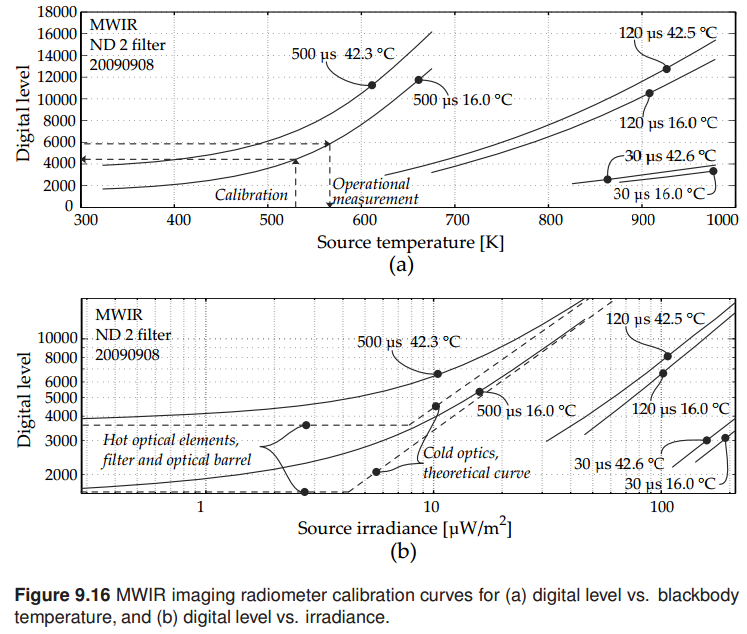

In [10]:
display(Image(filename='images/radiometry08.PNG'))

## Calculating a practical instrument function

Load the calibration data, presumably done with a blackbody and at short range.

In [11]:
calData = ryptw.JadeCalibrationData('./lwir100mm150us10ND20090910.xml', '.')


The calibration file contains all the information required to calculate the instrument function of the camera.  It lists the filenames for the various spectral parameters (sensor response, optics transmittance, source emissivity, and atmospheric transmittance).  The file also contains key sensor parameters such as detector pitch and fill factor and focal length.  The most important information is  the list of camera digital levels versus source temperature, for one or two instrument temperatures. By convention, the temperature in this file must be in degrees celcius.  An example file contents is shown below.

Two elements in this file are not measured but must be determined as part of the data analysis process:  

    JadeCalibration/Caldatas/Caldata@DlFloor
    JadeCalibration/Caldatas/Caldata@Power

    <JadeCalibration Name="lwir100mm0150us10ND20090910" ID="lwir100mm10ND" Version="" Summary="" >
        <SensorResponse Filename="LWIRsensor.txt"/>
        <OpticsTransmittance Filename="LW100mmLens.txt"/>
        <Filter Filename="LWND10.txt"/>
        <SourceEmis Filename="Unity.txt"/>
        <AtmoTau Filename="Unity.txt"/>
        <DetectorPitch Value="30e-6"/>
        <FillFactor Value="0.7"/>
        <Focallength Value="0.1"/>
        <IntegrationTime Value="150e-6"/>
        <Fnumber Value="2"/>
        <Nu Min="700" Max="1665" Inc="5" />
        <Caldatas>
            <Caldata InstrTemperature="17.1" DlFloor="3625" Power="10" >
                <CalPoint Temp="50" DL="4571" Comment="temp in deg C" />	
                <CalPoint Temp="100" DL="5132" />	
                <CalPoint Temp="150" DL="5906" />	
                <CalPoint Temp="200" DL="6887" />		
                <CalPoint Temp="250" DL="8034" />	
                <CalPoint Temp="300" DL="9338" />	
                <CalPoint Temp="350" DL="10834" />		
                <CalPoint Temp="400" DL="12386" />		
                <CalPoint Temp="450" DL="14042" />		
                <!-- <CalPoint Temp="500" DL="15324" />	-->    
            </Caldata>
            <Caldata InstrTemperature="34.4"  DlFloor="4210" Power="10"  >
                <CalPoint Temp="50" DL="5477"  Comment="temp in deg C" />
                <CalPoint Temp="100" DL="6050" />
                <CalPoint Temp="150" DL="6817" />	
                <CalPoint Temp="200" DL="7789" />
                <CalPoint Temp="250" DL="8922" />
                <CalPoint Temp="300" DL="10262" />
                <CalPoint Temp="350" DL="11694" />	
                <CalPoint Temp="400" DL="13299" />	
                <CalPoint Temp="450" DL="14921" />	
            </Caldata>
        </Caldatas>
    </JadeCalibration>

The __init___() function loads the data and calculates the mapping functions between digital level, radiance and temperature. 
Using the spectral curves and DL vs. temperature calibration inputs it calculate the various mapping functions between digital level, radiance and temperature. 

When loaded, plot the spectral data for inspection.
The various plot functions plot the data to a series of files with hard-coded filenames, built up from the name of the calibration file, with an appropriate added string.

In [12]:
print(calData.Info())

Path to XML                  = .
Path to datafiles            = .
Calibration Name             = lwir100mm0150us10ND20090910
ID                           = lwir100mm10ND
Version                      = 
Summary                      = 
DetectorPitch                = 3e-05
FillFactor                   = 0.7
Focallength                  = 0.1
integrationTime              = 0.00015
Fnumber                      = 2.0
Lookup Name          = lwir100mm0150us10ND20090910
Sensor Response      = ./LWIRsensor.txt
Optics Transmittance = ./LW100mmLens.txt
Filter               = ./LWND10.txt
Source Emissivity    = ./Unity.txt
Atmospheric Transm   = ./Unity.txt
Nu (Min, Max, Inc)   = (700.0, 1665.0, 5.0)
Calibration data set

Instrument temperature = 17.1 C
DL floor               = 3625.0
DL power               = 10.0
     Temp K           DL       L W/(sr.m2) [with filter]
[[  3.2315e+02   4.5710e+03   4.4507e+00]
 [  3.7315e+02   5.1320e+03   8.3094e+00]
 [  4.2315e+02   5.9060e+03   1.3496e+01]
 [  

In [13]:
calData.LU.PlotSpectrals()
HTML('<img src="images/lwir100mm0150us10ND20090910-spectrals.png" width=800 />')
# display(Image(filename='lwir100mm0150us10ND20090910-spectrals.png'))

C:\Anaconda\lib\site-packages\matplotlib\transforms.py:656: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


The following graph plots the source radiance versus source temperature, for the instrument spectral response, as defined in the input files.

In [14]:
calData.LU.PlotCalTempRadiance()
HTML('<img src="images/lwir100mm0150us10ND20090910-CalTempRadiance.png" width=800 />')
# display(Image(filename='lwir100mm0150us10ND20090910-CalTempRadiance.png'))

The radiance caused by the hot optics in the spectral band is as follows:

In [27]:
calData.LU.PlotCalTintRad()
HTML('<img src="lwir100mm0150us10ND20090910-CalInternal.png" width=800/>')
# display(Image(filename='lwir100mm0150us10ND20090910-CalInternal.png'))

Plot the spectral radiance data for the temperatures used in the calibration process:

In [16]:
calData.LU.PlotCalSpecRadiance()
HTML('<img src="images/lwir100mm0150us10ND20090910-CalRadiance.png" width=800/>')
# display(Image(filename='lwir100mm0150us10ND20090910-CalRadiance.png'))

The instrument function is nominally a straight line, but flattens out at the low and high ends. At the low end, the (constant) radiance in the optics and instrument dominates the incoming flux on the detector, resulting in an asymptotic lower limit in digital level.  At the top end, the detector or digitiser saturates, resulting in an asymptotic line at the maximum recordable level.  In practice, the top-end asymptotic line is avoided simply by not using the instrument at these signal levels.  The low-end asymptotic line is always present and must always be accounted for.  

The low-end asymptotic line is defined by a set of two parameters in the input file (one set each for each instrument temperature):  

    JadeCalibration/Caldatas/Caldata@DlFloor
    JadeCalibration/Caldatas/Caldata@Power
    
These two parameters are not directly measurable and must be determined by an iterative process.    This is done by entering estimates into the data file and then plotting the two graphs below, changing the values until you are satisfied with the graph.  The `DlFloor` parameter determines the asymptotic limit, and the `Power` value determines the shape of the transition between the asymptotic line and the linear portion of the instrument function.

In [17]:
calData.LU.PlotCalDLRadiance()
HTML('<img src="images/lwir100mm0150us10ND20090910-CaldlRadiance.png" width=800/>')
# display(Image(filename='lwir100mm0150us10ND20090910-CaldlRadiance.png'))

In [18]:
calData.LU.PlotCalDLTemp()
HTML('<img src="images/lwir100mm0150us10ND20090910-CalDLTemp.png" width=800 />')
# display(Image(filename='lwir100mm0150us10ND20090910-CalDLTemp.png'))

Finally, print out the calibration data and instrument function:

In [19]:
print(calData.LU.Info())

Lookup Name          = lwir100mm0150us10ND20090910
Sensor Response      = ./LWIRsensor.txt
Optics Transmittance = ./LW100mmLens.txt
Filter               = ./LWND10.txt
Source Emissivity    = ./Unity.txt
Atmospheric Transm   = ./Unity.txt
Nu (Min, Max, Inc)   = (700.0, 1665.0, 5.0)
Calibration data set

Instrument temperature = 17.1 C
DL floor               = 3625.0
DL power               = 10.0
     Temp K           DL       L W/(sr.m2) [with filter]
[[  3.2315e+02   4.5710e+03   4.4507e+00]
 [  3.7315e+02   5.1320e+03   8.3094e+00]
 [  4.2315e+02   5.9060e+03   1.3496e+01]
 [  4.7315e+02   6.8870e+03   1.9920e+01]
 [  5.2315e+02   8.0340e+03   2.7452e+01]
 [  5.7315e+02   9.3380e+03   3.5957e+01]
 [  6.2315e+02   1.0834e+04   4.5307e+01]
 [  6.7315e+02   1.2386e+04   5.5385e+01]
 [  7.2315e+02   1.4042e+04   6.6092e+01]]
straight line fit L = 0.00648891790325 DL + -24.9024084808

Instrument temperature = 34.4 C
DL floor               = 4210.0
DL power               = 10.0
     Temp K 

The two instrument functions (at low and high instrument temperatures) are known, the instrument function for any arbitrary  instrument temperature can now be determined by interpolation (linear in this case).

The following code is used to verify digital-level-values for temperatures at the measured instrument temperatures and then demonstrates the interpolation of the instrument function at an intermediate instrument temperature.


In [20]:
for Tint in [17.1]:
  for DL in [4571, 5132, 5906, 6887, 8034, 9338, 10834, 12386, 14042 ]:
    print('Tint={} DL={} T={:.1f} L={:.0f}'.format(Tint, DL, calData.LU.LookupDLTemp(DL, Tint)-273.15, calData.LU.LookupDLRad(DL, Tint)))
print('----------------------------------------- ')
for Tint in [34.4]:
  for DL in [5477, 6050, 6817, 7789, 8922, 10262, 11694, 13299, 14921 ]:
    print('Tint={} DL={} T={:.1f} L={:.0f}'.format(Tint, DL, calData.LU.LookupDLTemp(DL, Tint)-273.15, calData.LU.LookupDLRad(DL, Tint)))
print('----------------------------------------- ')
for Tint in [25]:
  for DL in [5477, 6050, 6817, 7789, 8922, 10262, 11694, 13299, 14921 ]:
    print('Tint={} DL={} T={:.1f} L={:.0f}'.format(Tint, DL, calData.LU.LookupDLTemp(DL, Tint)-273.15, calData.LU.LookupDLRad(DL, Tint)))


Tint=17.1 DL=4571 T=50.0 L=4
Tint=17.1 DL=5132 T=99.8 L=8
Tint=17.1 DL=5906 T=149.1 L=13
Tint=17.1 DL=6887 T=199.0 L=20
Tint=17.1 DL=8034 T=248.6 L=27
Tint=17.1 DL=9338 T=298.5 L=36
Tint=17.1 DL=10834 T=350.5 L=45
Tint=17.1 DL=12386 T=400.4 L=55
Tint=17.1 DL=14042 T=450.6 L=66
----------------------------------------- 
Tint=34.4 DL=5477 T=50.1 L=4
Tint=34.4 DL=6050 T=100.4 L=8
Tint=34.4 DL=6817 T=149.2 L=13
Tint=34.4 DL=7789 T=198.8 L=20
Tint=34.4 DL=8922 T=248.0 L=27
Tint=34.4 DL=10262 T=299.5 L=36
Tint=34.4 DL=11694 T=349.3 L=45
Tint=34.4 DL=13299 T=401.1 L=56
Tint=34.4 DL=14921 T=450.4 L=66
----------------------------------------- 
Tint=25 DL=5477 T=95.6 L=8
Tint=25 DL=6050 T=134.3 L=12
Tint=25 DL=6817 T=176.5 L=17
Tint=25 DL=7789 T=221.8 L=23
Tint=25 DL=8922 T=268.2 L=30
Tint=25 DL=10262 T=317.6 L=39
Tint=25 DL=11694 T=366.0 L=48
Tint=25 DL=13299 T=416.6 L=59
Tint=25 DL=14921 T=465.0 L=69


## Instrument function applied for temperature measurement (unity emissivity)

The following measurement observed a large-area blackbody in the lab.
The blackbody set point was 150 $^\circ$C and a recording made. The Cedip Altair s/w calculated 157 $^\circ$C in the centre area of the source.   The ryptw module calculates a temperature of 149 $^\circ$C.

In this analysis we use the calibration file that was analysed above. The instrument (housing) temperature for the relevant frame is extracted from the header frame.  Once the instrument internal temperature is known, it is used to interpolate a curve between the two extreme instrument functions.  With the instrument function known at the operational temperature, the source temperature is calculated from the digital levels in the ptw file.

In [21]:
import os.path

#load the calibration file and calculate the instrument functon
calData = ryptw.JadeCalibrationData('./lwir100mm150us10ND20090910.xml', '.')

#load the ptw file header
ptwfile  = 'LWIR-BBref-150C-150us.ptw'
header = ryptw.readPTWHeader(ptwfile)
# showHeader(header)

#loading sequence of frames
framesToLoad = [1,2]
for frame in framesToLoad:
    data = ryptw.getPTWFrame (header, frame)
    
    #get the internal temperature from the header and use here
    tempIm = calData.LU.LookupDLTemp(data, header.h_HousingTemperature1-273.15)
    
    print('Instrument temperature during measurement was {:.2f} C'.format(header.h_HousingTemperature1-273.15))
  
    print('Temperature at ({},{})={} C'.format(160,120,tempIm[160,120]-273.15))
    print('Temperature at ({},{})={} C'.format(140,110,tempIm[140,110]-273.15))
    
    I = ryplot.Plotter(4, 1, 1,'', figsize=(6,6))
    I.showImage(1, tempIm, ptitle='{}, frame {}, temperature in K'.format(ptwfile[:-4],frame), titlefsize=7, cbarshow=True, cbarfontsize=7)
    I.saveFig('{}-{}.png'.format(os.path.basename(ptwfile)[:-4],frame))



Instrument temperature during measurement was 31.18 C
Temperature at (160,120)=148.400059244 C
Temperature at (140,110)=149.577057763 C
Instrument temperature during measurement was 31.18 C
Temperature at (160,120)=148.17586905 C
Temperature at (140,110)=149.521010215 C


In [22]:
# display(Image(filename='LWIR-BBref-150C-150us-1.png'))
HTML('<img src="images/LWIR-BBref-150C-150us-1.png" width=800 />')


## Instrument function applied for temperature measurement (spectral emissivity)

To follow.

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [22]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.8 32bit [MSC v.1500 32 bit (Intel)]
IPython 3.0.0
OS Windows 7 6.1.7601 SP1
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
pyradi 0.1.55
Sat Apr 04 22:06:12 2015 South Africa Standard Time